# Profiling cosipy's spectral fitting

The goal of profiling is to identify bottlenecks that make a code slow and make the process of optimizing it more efficient. Our time will be better spent e.g. improving by 30% a piece of code that takes 80% of the whole run time, vs improving by 90% a line that takes only 5%. 

On this example we will try to understand what takes the most time out of the spectral fitting. We will focus on the fitting itself, rathen that the time it takes to load and reduce the data ---we should also do that later.

## Setup

This is based on cosipy's spectral fitting example: https://github.com/cositools/cosipy/blob/main/docs/tutorials/SpectralFit.ipynb

First, the imports:

In [8]:
from cosipy import COSILike, BinnedData
from cosipy.coordinates.orientation import Orientation_file
from scoords import SpacecraftFrame, Attitude
from threeML import Band, PointSource, Model, JointLikelihood, DataList
from astropy.time import Time
import astropy.units as u

Then the inputs and initialization. This is also somewhat slow, but again, we will not profile this for now.

In [25]:
%%time
ori = Orientation_file.parse_from_file("data/20280301_first_2hrs.ori")
Timemin = Time(1835481433.0,format = 'unix')
Timemax = Time(1835481435.0,format = 'unix')
sc_orientation = ori.source_interval(Timemin, Timemax)

bkg_data = BinnedData("data/grb_dataIO_config.yml")
bkg_data.load_binned_data_from_hdf5('data/bkg_binned_data.hdf5')

grb_data = BinnedData("data/grb_dataIO_config.yml")
grb_data.load_binned_data_from_hdf5('data/grb_bkg_binned_data.hdf5')

response_path = "data/FlatContinuumIsotropic.LowRes.binnedimaging.imagingresponse.area.nside8.cosipy.h5" # path to detector response

data = grb_data.binned_data.project('Em', 'Phi', 'PsiChi')
bkg = bkg_data.binned_data.project('Em', 'Phi', 'PsiChi')/3600

CPU times: user 54.3 s, sys: 36.3 s, total: 1min 30s
Wall time: 2min 4s


In [26]:
%%time

cosi = COSILike("cosi",                                                       # COSI 3ML plugin
                dr = response_path,                                                      # detector response
                data = data,    # data 
                bkg = bkg,         # background model 
                sc_orientation = ori )                             # spacecraft orientation

spectrum = Band()
alpha = -1.                                        # Setting parameters to something reasonable helps the fitting to converge
beta = -3.
xp = 1000 * u.keV
piv = 500 * u.keV
K = 0.00247 / u.cm / u.cm / u.s / u.keV
spectrum.alpha.value = alpha
spectrum.beta.value = beta
spectrum.xp.value = xp.value
spectrum.K.value = K.value
spectrum.piv.value = piv.value
spectrum.xp.unit = xp.unit
spectrum.K.unit = K.unit
spectrum.piv.unit = piv.unit

source = PointSource("source",                     # Name of source (arbitrary, but needs to be unique)
                     l = 51.,                      # Longitude (deg)
                     b = -17.,                     # Latitude (deg)
                     spectral_shape = spectrum)    # Spectral model

model = Model(source)                              # Model with single source. If we had multiple sources, we would do Model(source1, source2, ...)

# Optional: if you want to call get_log_like manually, then you also need to set the model manually
# 3ML does this internally during the fit though
cosi.set_model(model)

plugins = DataList(cosi) # If we had multiple instruments, we would do e.g. DataList(cosi, lat, hawc, ...)

like = JointLikelihood(model, plugins, verbose = False)

17:16:53 INFO      set the minimizer to minuit                                             ]8;id=406753;file:///Users/israel/work/software/miniconda3/envs/cosi/lib/python3.8/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=582485;file:///Users/israel/work/software/miniconda3/envs/cosi/lib/python3.8/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

CPU times: user 1min 2s, sys: 9.06 s, total: 1min 11s
Wall time: 1min 22s


This is a temporary workaround to reduce the verbosity while we fix some (benign) warnings:

In [28]:
import warnings

warnings.simplefilter('ignore', RuntimeWarning)

And finally, this is the actual function we want to profile. Let's run it first as is:

In [29]:
%%time
like.fit(quiet = True)

17:17:41 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=263233;file:///Users/israel/work/software/miniconda3/envs/cosi/lib/python3.8/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=793636;file:///Users/israel/work/software/miniconda3/envs/cosi/lib/python3.8/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

         WARNING   50.239999999999995 percent of samples have been thrown away because     ]8;id=934385;file:///Users/israel/work/software/miniconda3/envs/cosi/lib/python3.8/site-packages/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=238564;file:///Users/israel/work/software/miniconda3/envs/cosi/lib/python3.8/site-packages/threeML/analysis_results.py#1737\1737]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

CPU times: user 19.2 s, sys: 4.33 s, total: 23.6 s
Wall time: 24.5 s


(                                     value  negative_error  positive_error   
 source.spectrum.main.Band.K       0.000401   -2.824544e-05    3.160028e-05  \
 source.spectrum.main.Band.alpha   0.020058   -1.630003e-02    1.799281e-02   
 source.spectrum.main.Band.xp     20.651137   -8.974658e-01    9.480504e-01   
 source.spectrum.main.Band.beta   -1.600000   -2.504861e-07   -3.896615e-08   
 
                                         error             unit  
 source.spectrum.main.Band.K      2.992286e-05  1 / (cm2 keV s)  
 source.spectrum.main.Band.alpha  1.714642e-02                   
 source.spectrum.main.Band.xp     9.227581e-01              keV  
 source.spectrum.main.Band.beta   1.057600e-07                   ,
        -log(likelihood)
 cosi       -7888.173914
 total      -7888.173914)

## Profiling

### Function-wise

We will use `cProfile`, a built in Python profiler. 

In [30]:
import cProfile

Now you can call `cProfile.run`, which will tell you the total run time, as well as the following statistics for each function:
- `ncalls`: number of times the function was executed
- `tottime`: time spent in the function itself excluding time spent on functions called within
- `percall`: `tottime`/`ncalls`
- `tottime`: time spent in the function including the time spent on functions called within

In [37]:
cProfile.run('like.fit(quiet = True)', sort = 'cumtime')

17:22:21 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=524955;file:///Users/israel/work/software/miniconda3/envs/cosi/lib/python3.8/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=263030;file:///Users/israel/work/software/miniconda3/envs/cosi/lib/python3.8/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

17:22:22 WARNING   49.46 percent of samples have been thrown away because they failed the  ]8;id=47547;file:///Users/israel/work/software/miniconda3/envs/cosi/lib/python3.8/site-packages/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=19780;file:///Users/israel/work/software/miniconda3/envs/cosi/lib/python3.8/site-packages/threeML/analysis_results.py#1737\1737]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

         1812949 function calls (1749244 primitive calls) in 8.625 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    8.625    8.625 {built-in method builtins.exec}
        1    0.000    0.000    8.625    8.625 <string>:1(<module>)
        1    0.000    0.000    8.625    8.625 joint_likelihood.py:215(fit)
       91    0.011    0.000    8.474    0.093 COSILike.py:159(inner_fit)
       91    0.062    0.001    8.462    0.093 COSILike.py:132(get_log_like)
        1    0.000    0.000    8.398    8.398 minimization.py:620(minimize)
       90    0.005    0.000    8.395    0.093 joint_likelihood.py:933(minus_log_like_profile)
       91    0.004    0.000    7.214    0.079 COSILike.py:76(set_model)
        1    0.000    0.000    6.321    6.321 minuit_minimizer.py:178(_minimize)
        1    0.001    0.001    6.321    6.321 minuit.py:647(migrad)
      273    0.002    0.000    5.393    0.020 _sparse_array.

Alternatively, you can save the results into a file like this:

In [40]:
cProfile.run('like.fit(quiet = True)', filename = "fit.prof")

17:30:05 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=124932;file:///Users/israel/work/software/miniconda3/envs/cosi/lib/python3.8/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=145770;file:///Users/israel/work/software/miniconda3/envs/cosi/lib/python3.8/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

         WARNING   49.24 percent of samples have been thrown away because they failed the  ]8;id=217607;file:///Users/israel/work/software/miniconda3/envs/cosi/lib/python3.8/site-packages/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=419639;file:///Users/israel/work/software/miniconda3/envs/cosi/lib/python3.8/site-packages/threeML/analysis_results.py#1737\1737]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

And then use another tool to visualize it. In this case I used SnakeViz. You can install with 
`pip install snakeviz` and then call in the command line `snakeviz fit.prof`. This will open a webpage with an interactive plot like the follwing:


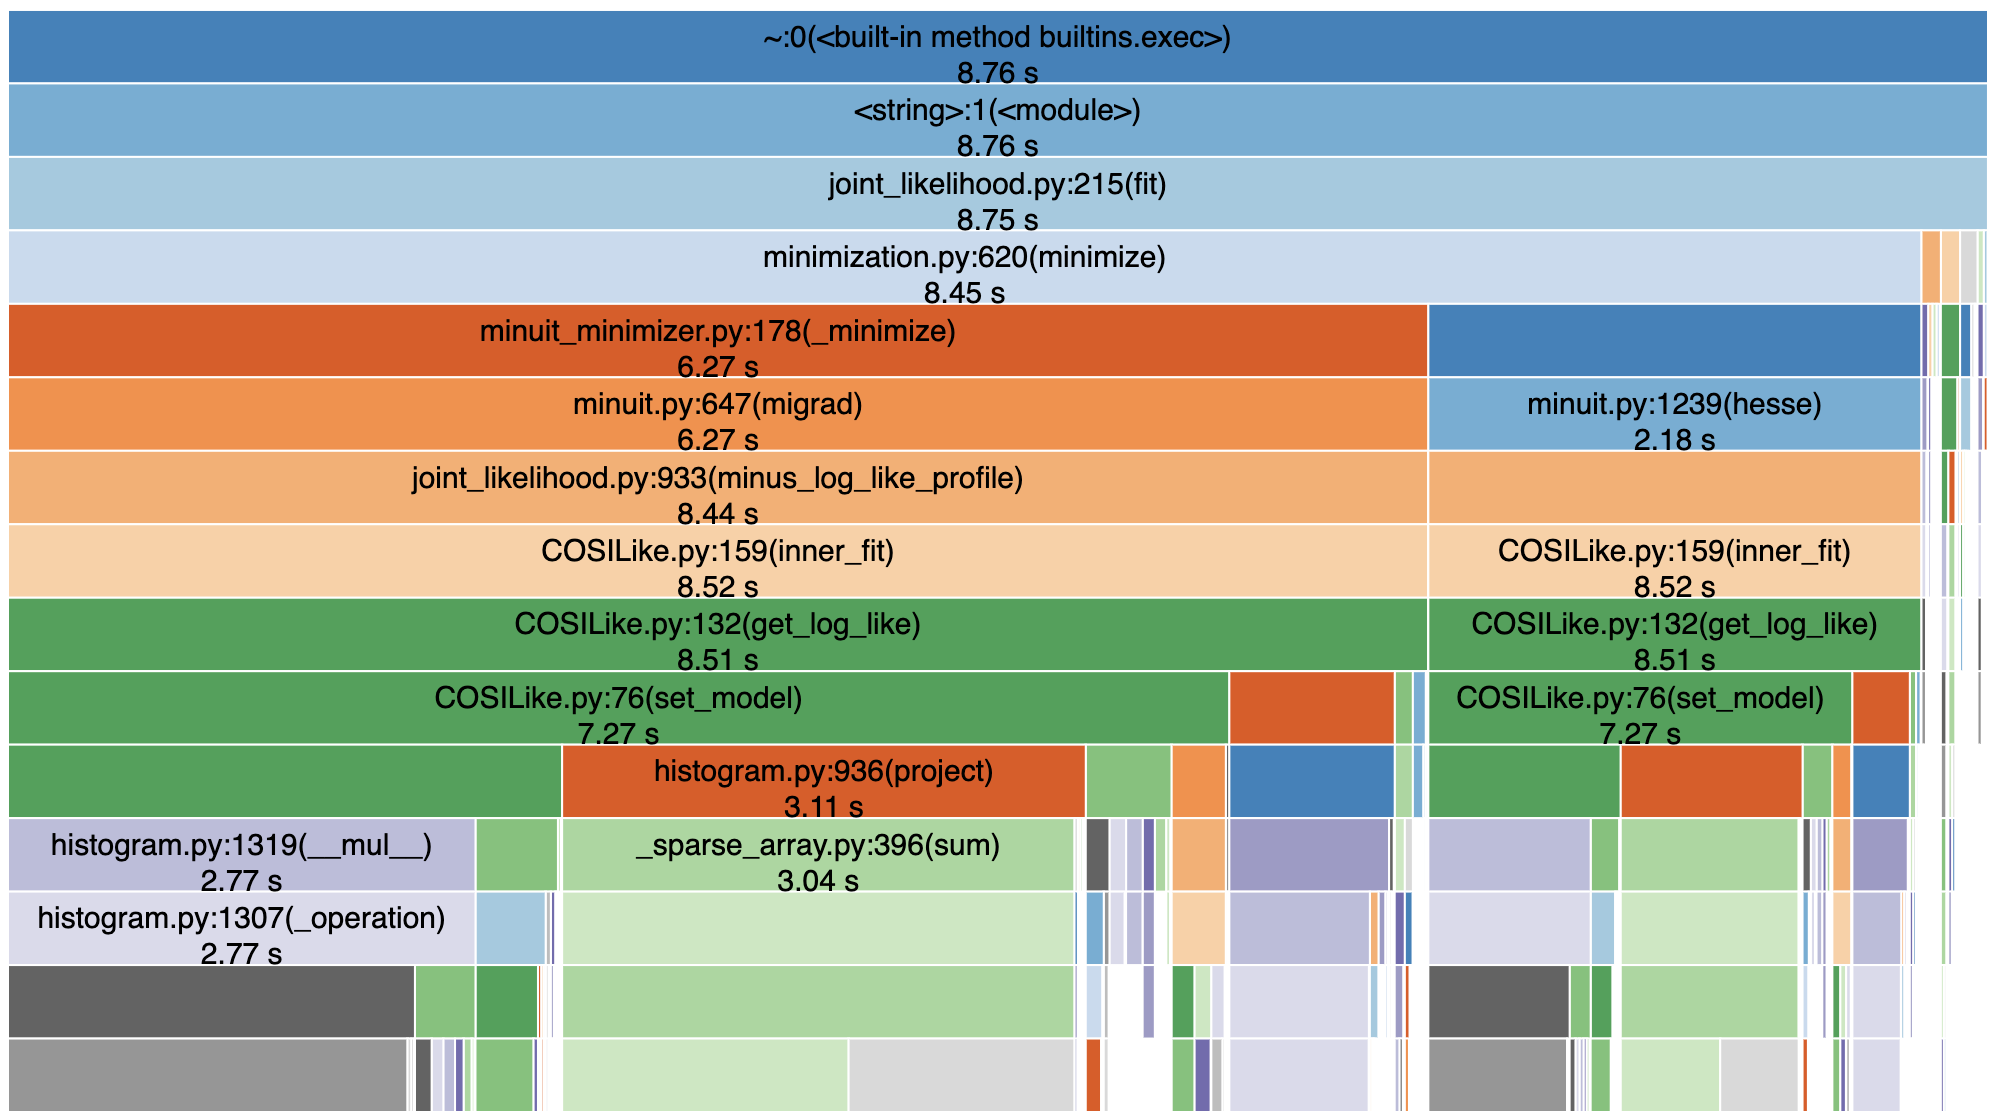

What this tells use is that most of the time is spent computing the likelihood, which is expecpted. However, it also tell us that most if this time is spent estimating the expected counts (`set_model`).

### Line-by-line

In order to know exactly where in the code this happend, we can use `lprun`. This will tell us the time spent line-by-line, as opposed to function-by-function. First, install it using `pip install line_profiler`, and the load it with:

In [41]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


The calling signature is
`%lprun -f <individual function you are going to profile>  <function you are going to run>`

Note that you pass the function you want to profile as an object --i.e. without `()`. e.g.

In [21]:
%lprun -f cosi.get_log_like like.fit(quiet = True)

17:01:19 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=101021;file:///Users/israel/work/software/miniconda3/envs/cosi/lib/python3.8/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=598282;file:///Users/israel/work/software/miniconda3/envs/cosi/lib/python3.8/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

         WARNING   50.080000000000005 percent of samples have been thrown away because     ]8;id=269988;file:///Users/israel/work/software/miniconda3/envs/cosi/lib/python3.8/site-packages/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=649026;file:///Users/israel/work/software/miniconda3/envs/cosi/lib/python3.8/site-packages/threeML/analysis_results.py#1737\1737]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Timer unit: 1e-09 s

Total time: 9.08541 s
File: /Users/israel/work/software/cosipy/cosipy/threeml/COSILike.py
Function: get_log_like at line 132

Line #      Hits         Time  Per Hit   % Time  Line Contents
   132                                               def get_log_like(self):
   133                                                   """
   134                                                   Return the value of the log-likelihood
   135                                                   """
   136                                                   
   137                                                   # Recompute the expectation if any parameter in the model changed
   138        91     108000.0   1186.8      0.0          if self._model is None:
   139                                                       log.error("You need to set the model first")
   140                                                   
   141        91 7725718000.0 84898000.0     85.0          self.set_m

This confirms that most of the time inside `get_log_like` is actually spent by `set_model` (85%). One of the main conclusions is that it's not worth spending time trying to further improve the computation of the likelihood itself (`log_like = np.nansum(data*np.log(expectation) - expectation)`) because that barely takes a couple percent.

Now let's deeper and see the line-line-like profiling of `set_model`

In [22]:
%lprun -f cosi.set_model like.fit(quiet = True)

17:01:35 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=738588;file:///Users/israel/work/software/miniconda3/envs/cosi/lib/python3.8/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=838954;file:///Users/israel/work/software/miniconda3/envs/cosi/lib/python3.8/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

         WARNING   50.019999999999996 percent of samples have been thrown away because     ]8;id=835592;file:///Users/israel/work/software/miniconda3/envs/cosi/lib/python3.8/site-packages/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=784003;file:///Users/israel/work/software/miniconda3/envs/cosi/lib/python3.8/site-packages/threeML/analysis_results.py#1737\1737]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Timer unit: 1e-09 s

Total time: 8.47369 s
File: /Users/israel/work/software/cosipy/cosipy/threeml/COSILike.py
Function: set_model at line 76

Line #      Hits         Time  Per Hit   % Time  Line Contents
    76                                               def set_model(self, model):
    77                                                   """
    78                                                   Set the model to be used in the joint minimization.
    79                                                   
    80                                                   Parameters:
    81                                                       model: LikelihoodModel
    82                                                           Any model supported by astromodel. However, this simple plugin only support single 
    83                                                           point-sources with a power law spectrum
    84                                                   """
    85           

It seems most of the time is spent on a single like of code: `self._signal = self._psr.get_expectation(spectrum).project(['Em', 'Phi', 'PsiChi'])`. This is what convolves a spectrum with the detector response.

From the cProfile/Snake we already now that 3.11s/8.76s is spent on the `project()` function, which is almost on its totallity performed by the `sum()` function of the [sparse](https://sparse.pydata.org/en/stable/) library.

The other component of that line is `get_expectation`:

In [42]:
from cosipy.response import PointSourceResponse
%lprun -f PointSourceResponse.get_expectation like.fit(quiet = True)

18:03:23 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=966792;file:///Users/israel/work/software/miniconda3/envs/cosi/lib/python3.8/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=821779;file:///Users/israel/work/software/miniconda3/envs/cosi/lib/python3.8/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

         WARNING   49.919999999999995 percent of samples have been thrown away because     ]8;id=184885;file:///Users/israel/work/software/miniconda3/envs/cosi/lib/python3.8/site-packages/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=315006;file:///Users/israel/work/software/miniconda3/envs/cosi/lib/python3.8/site-packages/threeML/analysis_results.py#1737\1737]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Timer unit: 1e-09 s

Total time: 3.59161 s
File: /Users/israel/work/software/cosipy/cosipy/response/PointSourceResponse.py
Function: get_expectation at line 45

Line #      Hits         Time  Per Hit   % Time  Line Contents
    45                                               def get_expectation(self, spectrum):
    46                                                   """
    47                                                   Convolve the response with a spectral hypothesis to obtain the expected
    48                                                   excess counts from the source.
    49                                           
    50                                                   Parameters
    51                                                   ----------
    52                                                   spectrum : :py:class:`threeML.Model`
    53                                                       Spectral hypothesis.
    54                                        

Which shows that most of the time is spent on a matrix multiplication (line 92). 

## Conclusions

Most of the time is spent on matrix operations that convolve the detector response with a spectrum. That is, a multiplication along the axis 'Ei' and sum/projection onto the axes 'Em' and the CDS. Here are some possible avenues to explore:

* Prevent this operation when only the normalization is changed. Instead, only scale the overal expectation. This is specially important for the TS maps.
* Use "region of interes" around the Compton cone. Note: Andreas noted that the tails of the ARM distribution are heavy, and this might not be possible.
* Find if we are using the sparse library in a suboptimal way.
* Use alternative libraries that can parallelize this operation and/or use GPUs.